# Early Stopping or Smaller Ensembles

*This notebook first appeared as a [blog post](//betatim.github.io/posts/bumping) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2016, Tim Head.*
*Feel free to use, distribute, and modify with the above attribution.*

When building an ensemble of trees (a Random Forest or via gradient boosting) one question keeps coming up: how many weak learners should I add to my ensemble?

This post shows you how to keep growing your ensemble until the test error reaches a minimum. This means you do not end up wasting time waiting for your ensemble to build 1000 trees if you only need 200.

First a few imports and generating a toy dataset:

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [3]:
X, y = make_classification(n_samples=4000,
                           n_features=40,
                           n_informative=10,
                           n_clusters_per_class=3,
                           random_state=2)
# Split data into a development and evaluation set
X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                              train_size=0.5,
                                              random_state=3)
# Split development set into a train and test set
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev,
                                                  test_size=0.33, random_state=4)

## How many trees?

To get started we build an ensemble of 400 trees using gradient boosting. Without
knowing how many trees are needed to reach the minimum test error we can just hope
that 400 is enough. One downside is that we might be waiting a long time to fit a
model with this many trees and then learn that we only needed a small fraction of them (say 200).

In [4]:
opts = dict(max_depth=2, learning_rate=0.1, n_estimators=400)
clf = GradientBoostingClassifier(**opts)
_ = clf.fit(X_train, y_train)

Next we plot the validation curve for our fitted classifier and check
with the test set at which number of `n_estimators` we reach the
minimum test error.

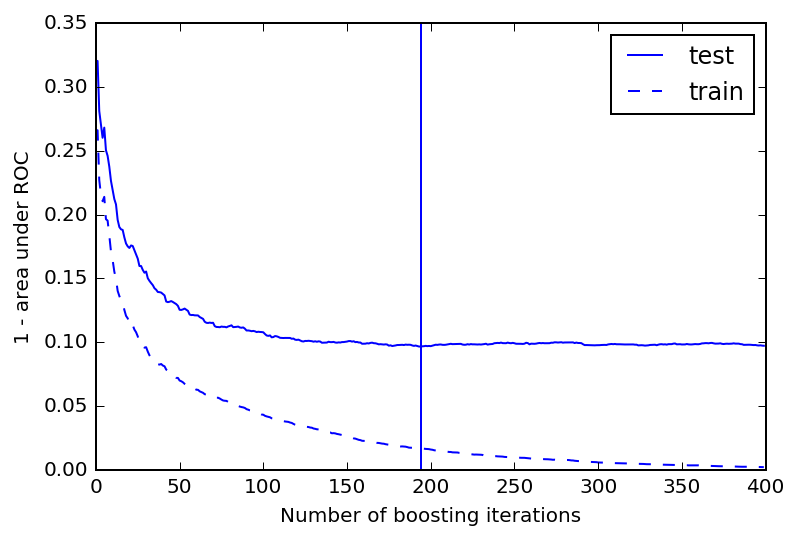

In [5]:
def validation_curve(clf):
    test_score = np.empty(len(clf.estimators_))
    train_score = np.empty(len(clf.estimators_))

    for i, pred in enumerate(clf.staged_predict_proba(X_test)):
        test_score[i] = 1-roc_auc_score(y_test, pred[:,1])

    for i, pred in enumerate(clf.staged_predict_proba(X_train)):
        train_score[i] = 1-roc_auc_score(y_train, pred[:,1])

    best_iter = np.argmin(test_score)
    test_line = plt.plot(test_score, label='test')

    colour = test_line[-1].get_color()
    plt.plot(train_score, '--', color=colour, label='train')

    plt.xlabel("Number of boosting iterations")
    plt.ylabel("1 - area under ROC")
    plt.legend(loc='best')
    plt.axvline(x=best_iter, color=colour)
    
validation_curve(clf)

As suspected we reach the minimum after approximately 200 iterations. After this the score
$1-\textrm{AUC}(\textrm{ROC})$ does not improve any further. In this case the performance
does not degrade noticably with more iterations but it does take more time to build a model with 400 trees instead of 200.

Now that we know the answer let's see if we can construct a meta estimator that would have
stopped at roughly 200 trees instead of fitting all 400.


## Early stopping

The obvious solution is to measure the performance of our ensemble as we go along and
stop adding trees once we think we have reached the minimum.

The `EarlyStopping` meta estimator takes an unfitted estimator, the maximum number
of iterations and a function to calculate the score as arguments.

It will repeatedly add one more base estimator to the ensemble, measure the performance,
and check if we reached minimum. If we reached the minimum it stops, otherwise it
keeps adding base estimators until it reaches the maximum number of iterations.

There are a few more details worth pointing out:

* there is a minimum number of trees required to skip over the noisier part of the score
  function; and
  
* `EarlyStopping` does not actually stop at the minimum, instead it continues on until
  the score has increased by `scale` above the current minimum. This is a simple solution
  to the problem that we only know we reached the minimum by seeing the score increase
  again.

In [6]:
from sklearn.base import ClassifierMixin, clone
from functools import partial


def one_minus_roc(X, y, est):
    pred = est.predict_proba(X)[:, 1]
    return 1-roc_auc_score(y, pred)


class EarlyStopping(ClassifierMixin):
    def __init__(self, estimator, max_n_estimators, scorer,
                 n_min_iterations=50, scale=1.02):
        self.estimator = estimator
        self.max_n_estimators = max_n_estimators
        self.scorer = scorer
        self.scale = scale
        self.n_min_iterations = n_min_iterations
    
    def _make_estimator(self, append=True):
        """Make and configure a copy of the `estimator` attribute.
        
        Any estimator that has a `warm_start` option will work.
        """
        estimator = clone(self.estimator)
        estimator.n_estimators = 1
        estimator.warm_start = True
        return estimator
    
    def fit(self, X, y):
        """Fit `estimator` using X and y as training set.
        
        Fits up to `max_n_estimators` iterations and measures the performance
        on a separate dataset using `scorer`
        """
        est = self._make_estimator()
        self.scores_ = []

        for n_est in range(1, self.max_n_estimators+1):
            est.n_estimators = n_est
            est.fit(X,y)
            
            score = self.scorer(est)
            self.estimator_ = est
            self.scores_.append(score)

            if (n_est > self.n_min_iterations and
                score > self.scale*np.min(self.scores_)):
                return self

        return self

We have all the ingredients, so let's take them for a spin. If `EarlyStopping` works it should
stop adding trees to the ensemble before we get to 200 trees.

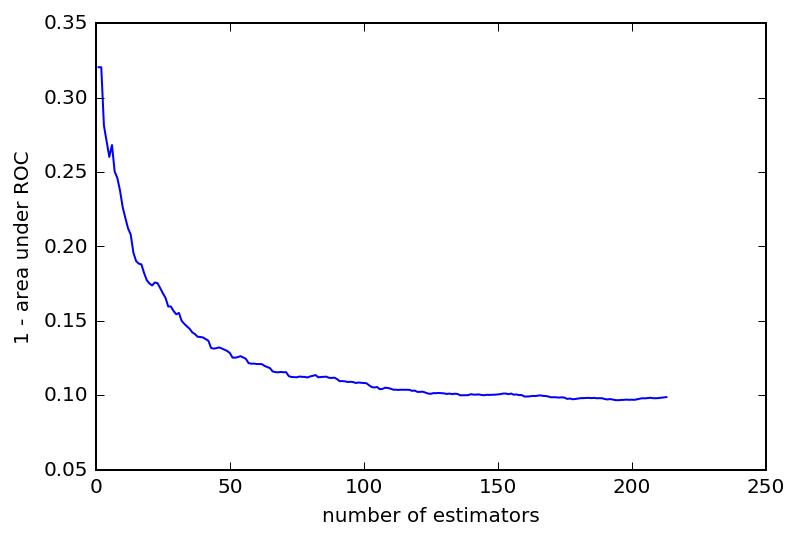

In [7]:
def stop_early(classifier, **kwargs):
    n_iterations = classifier.n_estimators
    early = EarlyStopping(classifier,
                          max_n_estimators=n_iterations,
                          # fix the dataset used for testing by currying
                          scorer=partial(one_minus_roc, X_test, y_test),
                          **kwargs)
    early.fit(X_train, y_train)
    plt.plot(np.arange(1, len(early.scores_)+1),
             early.scores_)
    plt.xlabel("number of estimators")
    plt.ylabel("1 - area under ROC")
    
stop_early(GradientBoostingClassifier(**opts), n_min_iterations=100)

## Success ?!

Looks like it works. The `EarlyStopping` meta estimator suggests that around 210 trees is
what is needed. While this is not in perfect agreement with what we found before, it is
pretty good given how simple a "minimisation" strategy we use.


## Homework

Remember we split the dataset into three parts? We reserved one part as evaluation set.
What is it good for? Should you quote the result from the test set as your best estimate
of the performance of your classifier? Try and answer that question using the evaluation
data set. Read my post on [unbiased performance estimates](//betatim.github.io/posts/unbiased-performance/) if you need some inspiration.



## Taking if further

There are several ways to build on what we have created so far. Three I can think of:

1. try it with other types of estimators
2. better methods for dealing with the noise inherent to the score function
3. deal with very flat score functions

One and two are connected. Using `EarlyStopping` with a `RandomForestClassifier`
works, however the score as a function of the number of estimators is much more
noisy. Right now this means quite a bit of hand tuning of the minimum number of
iterations and required increase (`scale`) to declare that we found a minimum.

To get you started, here a little snippet of using `EarlyStopping` with a random
forest.

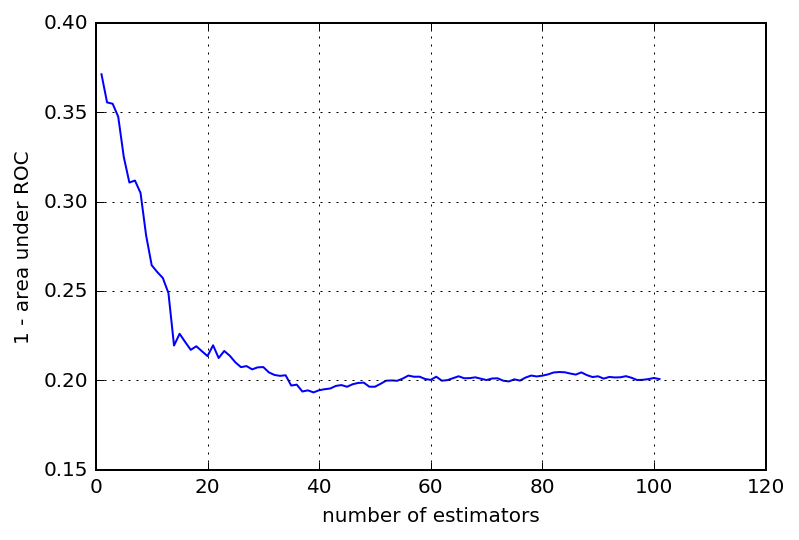

In [8]:
from sklearn.ensemble import RandomForestClassifier

stop_early(RandomForestClassifier(n_estimators=400, max_depth=2),
           n_min_iterations=100)
plt.grid()

If you find a mistake or want to tell me something else get in touch on twitter @[betatim](//twitter.com/betatim)